##  Working with a Non Stationary data:
## Data set: Light weight truck sales data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series

In [19]:
import os
os.chdir('/Users/revanthkota/downloads')

In [20]:
series1 = Series.from_csv('ALTSALES.csv', header=0) 

### ALTSALES.csv : Light weight trucks sales data. 

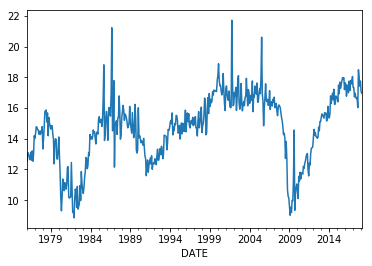

In [21]:
series1.plot()
plt.show()

In [105]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [106]:
decomposed = sm.tsa.seasonal_decompose(series1.values, model='additive' ,freq=12)

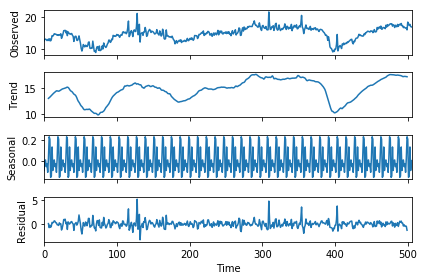

In [107]:
decomposed.plot()
plt.show()

### By decomposing time series, we can see that there is no standard trend in data 
### As sales increase and decrease over the time
### We can see that there is seasonality

In [110]:
decomposed = sm.tsa.seasonal_decompose(series1.values, model='additive' ,freq=4)

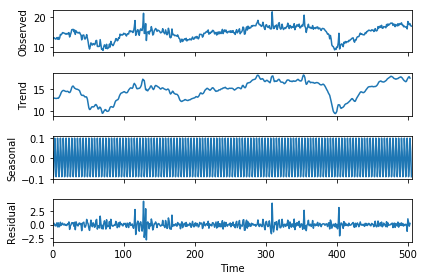

In [111]:
decomposed.plot()
plt.show()

In [112]:
# Dickey fuller test:

x = series1.values
result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.034039
p-value: 0.271850
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


### The above time series is Non stationary as P values is greater than 0.05

### Performed seasonal differencing of 1st Order in an attempt to stationarize the data

In [113]:
seasonal_difference = series1 - series1.shift(12)

In [114]:
# Dickey fuller test:

y = seasonal_difference.dropna()
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.912829
p-value: 0.001942
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


### Here we can see that after first differencing the sales data of light weight trucks is stationarized as it's P value is less than 0.05

### Plotted ACF AND PACF Plots to determine the order of differenced sales data

In [77]:
import statsmodels.graphics.tsaplots as tsaplots

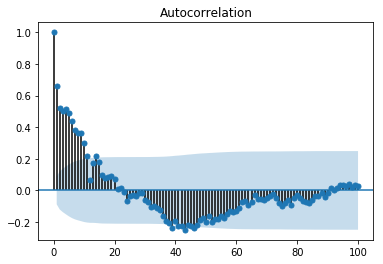

In [79]:
tsaplots.plot_acf(seasonal_difference.dropna(), lags = 100)

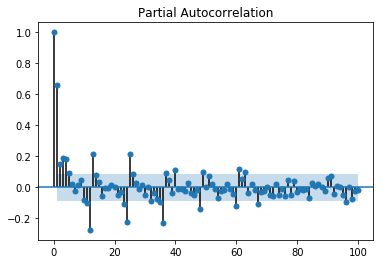

In [80]:
tsaplots.plot_pacf(seasonal_difference.dropna(), lags = 100)

### From the above plot, we can see that differenced sales data is an ARMA process.

### So, instead of using a Linear model to forecast sales

### I used Non linear model, LSTM Neural Nets to forecast sales before and after stabilizing data by seasonal differencing 
### Used LSTM Model with 4 neurons and 100 epochs.

### Below are two forecast results 
### before and after stationarizing sales data by seasonal differencing

## Case 1: Before stationarizing Data

Month=1, Predicted=3.128731, Expected=10.817000
Month=2, Predicted=3.580904, Expected=11.060000
Month=3, Predicted=3.825219, Expected=10.668000
Month=4, Predicted=3.416617, Expected=10.108000
Month=5, Predicted=2.862783, Expected=11.553000
Month=6, Predicted=4.381949, Expected=11.249000
Month=7, Predicted=3.997144, Expected=11.822000
Month=8, Predicted=4.613437, Expected=11.385000
Month=9, Predicted=4.137127, Expected=11.715000
Month=10, Predicted=4.501349, Expected=11.802000
Month=11, Predicted=4.575414, Expected=11.703000
Month=12, Predicted=4.469539, Expected=12.199000
Month=13, Predicted=4.991833, Expected=12.070000
Month=14, Predicted=4.832768, Expected=12.383000
Month=15, Predicted=5.167731, Expected=12.547000
Month=16, Predicted=5.323410, Expected=12.815000
Month=17, Predicted=5.596010, Expected=12.984000
Month=18, Predicted=5.760161, Expected=13.037000
Month=19, Predicted=5.808889, Expected=11.980000
Month=20, Predicted=4.731242, Expected=11.581000
Month=21, Predicted=4.344960,

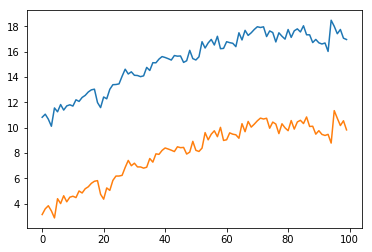

In [101]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime(x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=12):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
series = read_csv('ALTSALES.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-100], supervised_values[-100:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-100:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-100:])
pyplot.plot(predictions)
pyplot.show()

### Based on the results predicted on non stationarized data

###  we can see that LSTM Models are just replicating some pattern in data

### LSTM models are failing in forecasting sales data as RMS error in forecasting Is 7.311 

## Case 2: After stationarizing Data

Month=1, Predicted=10.077825, Expected=10.141000
Month=2, Predicted=10.804842, Expected=9.574000
Month=3, Predicted=11.146881, Expected=9.023000
Month=4, Predicted=10.872128, Expected=9.552000
Month=5, Predicted=10.376185, Expected=9.197000
Month=6, Predicted=12.198038, Expected=9.996000
Month=7, Predicted=12.101322, Expected=9.956000
Month=8, Predicted=12.769087, Expected=11.370000
Month=9, Predicted=12.262516, Expected=14.567000
Month=10, Predicted=12.144432, Expected=9.346000
Month=11, Predicted=10.684989, Expected=10.370000
Month=12, Predicted=12.618979, Expected=10.817000
Month=13, Predicted=12.940367, Expected=11.060000
Month=14, Predicted=12.929556, Expected=10.668000
Month=15, Predicted=13.192876, Expected=10.108000
Month=16, Predicted=13.621494, Expected=11.553000
Month=17, Predicted=14.257914, Expected=11.249000
Month=18, Predicted=14.172553, Expected=11.822000
Month=19, Predicted=14.317385, Expected=11.385000
Month=20, Predicted=12.549443, Expected=11.715000
Month=21, Predic

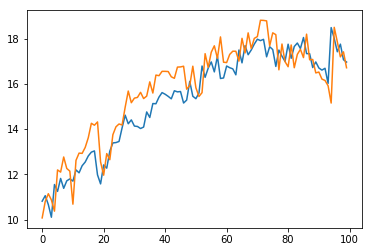

In [115]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime(x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=12):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
series = read_csv('ALTSALES.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 12) 
# Performed a seasonal yearly differencing (interval = 12 months) to stationarize the data.

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-100], supervised_values[-100:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-100:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-100:])
pyplot.plot(predictions)
pyplot.show()

### After stationarizing data by removing seasonality, 
### we can see that the error in forecast has decreased drastically by 7 units.

## Conclusions:

### Based on above observations we can say that Neural Networks are best at capturing underlying patterns in data and replicating them for future values.

### Hence, neural nets are to be used in specific applications like voice or pattern recognition, image processing where output data has a pattern and we are trying to understand and replicate the same pattern. 

### In time series application, we should use neural networks for predictions once the data is stationarized as by stationarizing data we are trying to say that future values depend on past values and the pattern continues.

### By applying neural networks on non stationary data, though neural net might be able to capture the pattern in data it does a poor job in forecasting as it fails to understand underlying data generation process and  does not replicate data generation process there by performing poorly on new test data.